In [1]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from nilearn.plotting import plot_stat_map
from nilearn.image import load_img
import scipy.stats as stats
from nilearn import plotting, datasets
from nilearn.plotting import plot_anat, plot_stat_map, view_img
from scipy.ndimage import center_of_mass
from nilearn.image import resample_to_img
from scipy import stats
from netplotbrain import plot as netplot

In [2]:
def compute_barycenters(mask_path, exclude_regions, target_affine):
    """
    Compute barycenters for regions in a given NIfTI mask, aligned to the target atlas space.
    """
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata()
    unique_regions = np.unique(mask_data)[1:]  # Exclude background (0)

    coords = []
    included_regions = []
    for region in unique_regions:
        if region not in exclude_regions:
            region_mask = (mask_data == region)
            barycenter = center_of_mass(region_mask)
            coords.append(barycenter)
            included_regions.append(region)

    # Transform barycenters to target atlas space
    coords = np.array(coords)
    transformed_coords = nib.affines.apply_affine(target_affine, coords)
    return transformed_coords, included_regions

def extract_region_thickness(data_path, subject_files, mask_path, included_regions):
    """
    Extract region-wise cortical thickness data using a custom mask.
    """
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata()

    region_thickness = []
    for path in subject_files:
        subject_img = nib.load(data_path + path)
        resampled_img = resample_to_img(subject_img, mask_img, interpolation="nearest")
        resampled_data = resampled_img.get_fdata()

        subject_region_means = [
            np.median(resampled_data[mask_data == region]) for region in included_regions
        ]
        region_thickness.append(subject_region_means)

    return np.array(region_thickness)


def compute_structural_covariance(data):
    """
    Compute structural covariance as pairwise correlations between nodes.
    """
    n_regions = data.shape[1]
    corr_matrix = np.zeros((n_regions, n_regions))
    for i in range(n_regions):
        for j in range(i, n_regions):
            if np.std(data[:, i]) == 0 or np.std(data[:, j]) == 0:
                corr_matrix[i, j] = corr_matrix[j, i] = 0  # Avoid divide by zero
            else:
                corr_matrix[i, j] = corr_matrix[j, i] = np.corrcoef(data[:, i], data[:, j])[0, 1]
    return corr_matrix


def plot_network_on_brain(coords, adj_matrix, title, filename, template=None):
    """
    Plot the network on the brain using NetPlotBrain.
    """
    edges = []
    for i in range(adj_matrix.shape[0]):
        for j in range(i + 1, adj_matrix.shape[1]):
            if adj_matrix[i, j] != 0:
                edges.append({"i": i, "j": j, "weight": adj_matrix[i, j]})

    edges_df = pd.DataFrame(edges)
    nodes_df = pd.DataFrame(coords, columns=["x", "y", "z"])

    netplot(
        template="MNI152NLin2009cAsym",
        nodes=nodes_df,
        edges=edges_df,
        node_size=5,
        edge_color="weight",
        edge_cmap="coolwarm",
        margin=0.05,
        #view="preset-6",
        view = 'LRSP',
        savename=filename,
    )
    

In [3]:
# Paths to thickness data for two groups
group1_paths = [
    "IXI158.nii", "IXI204.nii", "IXI237.nii", "IXI251.nii", "IXI288.nii",
    "IXI383.nii", "IXI384.nii", "IXI399.nii", "IXI420.nii", "IXI433.nii",
    "IXI462.nii", "IXI464.nii", "IXI476.nii", "IXI491.nii", "IXI498.nii",
    "IXI518.nii", "IXI538.nii"
]
group2_paths = [
    "Patient1.nii", "Patient2.nii", "Patient3.nii", "Patient4.nii",
    "Patient5.nii", "Patient6.nii", "Patient8.nii", "Patient9.nii",
    "Patient10.nii", "Patient11.nii", "Patient12.nii"
]
group3_paths = ["SCA013.nii", "SCA029.nii", "SCA033.nii", "SCA039.nii",
                "SCA068.nii", "SCA069.nii", "SCA076.nii", "SCA077.nii",
                "SCA083.nii", "SCA084.nii", "SCA087.nii", "SCA090.nii",
                "SCA093.nii", "SCA094.nii", "SCA095.nii", "SCA096.nii",
                "SCA097.nii"
]
data_path="../data/normal_yo_SCA/"

In [4]:
# Load mask and compute barycenters
mask_path = "../data/mni_structures_job1687583.nii"
mask_img = nib.load(mask_path)
atlas = datasets.fetch_atlas_schaefer_2018()
target_affine = mask_img.affine
#target_affine = nib.load(atlas["maps"]).affine  # Get affine from atlas
exclude_regions = [13, 113]  # Exclude regions
coords, included_regions = compute_barycenters(mask_path, exclude_regions, target_affine)

[get_dataset_dir] Dataset found in /Users/tamara/nilearn_data/schaefer_2018


In [5]:
# Extract region-wise cortical thickness
group1_data = extract_region_thickness(data_path, group1_paths, mask_path, included_regions)
group2_data = extract_region_thickness(data_path, group2_paths, mask_path, included_regions)
group3_data = extract_region_thickness(data_path, group3_paths, mask_path, included_regions)


/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/2219936145.py:33: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = resample_to_img(subject_img, mask_img, interpolation="nearest")
/Users/tamara/anaconda3/envs/pcdanalysis/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [6]:
np.save('../data/group1_data.npy', group1_data)
np.save('../data/group2_data.npy', group2_data)
np.save('../data/group3_data.npy', group3_data)

# Load the array
group1_data = np.load('../data/group1_data.npy')
group2_data = np.load('../data/group2_data.npy')
group3_data = np.load('../data/group3_data.npy')

In [7]:
# Compute structural covariance matrices
corr_matrix_group1 = compute_structural_covariance(group1_data)
corr_matrix_group2 = compute_structural_covariance(group2_data)
corr_matrix_group3 = compute_structural_covariance(group3_data)

In [8]:
# Threshold matrices
threshold = 0.2
adj_matrix_group1 = np.where(np.abs(corr_matrix_group1) > threshold, corr_matrix_group1, 0)
adj_matrix_group2 = np.where(np.abs(corr_matrix_group2) > threshold, corr_matrix_group2, 0)
adj_matrix_group3 = np.where(np.abs(corr_matrix_group3) > threshold, corr_matrix_group3, 0)

In [9]:
# Compute difference matrix
diff_matrix = adj_matrix_group2 - adj_matrix_group1
diff_matrix_13 = adj_matrix_group3 - adj_matrix_group1
diff_matrix_23 = adj_matrix_group2 - adj_matrix_group3

In [10]:
from scipy.stats import ttest_ind

In [11]:
# Perform pairwise t-tests with FDR correction
n_nodes = group1_data.shape[1]
p_values = []
indices = []

# Collect p-values
for i in range(n_nodes):
    for j in range(i + 1, n_nodes):
        t_stat, p_value = ttest_ind(group1_data[:, i], group2_data[:, j])  # Pairwise comparison
        p_values.append(p_value)
        indices.append((i, j))


# Apply FDR correction
rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method="fdr_bh")

# Update significance matrix
sig_matrix = np.zeros((n_nodes, n_nodes))
for idx, (i, j) in enumerate(indices):
    if rejected[idx]:
        sig_matrix[i, j] = sig_matrix[j, i] = 1 - p_values_corrected[idx]


In [12]:
# Perform pairwise t-tests with FDR correction
n_nodes = group1_data.shape[1]
p_values = []
indices = []

# Collect p-values
for i in range(n_nodes):
    for j in range(i + 1, n_nodes):
        t_stat, p_value = ttest_ind(group1_data[:, i], group3_data[:, j])
        p_values.append(p_value)
        indices.append((i, j))

# Apply FDR correction
rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method="fdr_bh")

# Update significance matrix
sig_matrix_13 = np.zeros((n_nodes, n_nodes))
for idx, (i, j) in enumerate(indices):
    if rejected[idx]:
        sig_matrix_13[i, j] = sig_matrix_13[j, i] = 1 - p_values_corrected[idx]

In [13]:
# Perform pairwise t-tests with FDR correction
n_nodes = group1_data.shape[1]
p_values = []
indices = []

# Collect p-values
for i in range(n_nodes):
    for j in range(i + 1, n_nodes):
        t_stat, p_value = ttest_ind(group2_data[:, i], group3_data[:, j])
        p_values.append(p_value)
        indices.append((i, j))

# Apply FDR correction
rejected, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method="fdr_bh")

# Update significance matrix
sig_matrix_23 = np.zeros((n_nodes, n_nodes))
for idx, (i, j) in enumerate(indices):
    if rejected[idx]:
        sig_matrix_23[i, j] = sig_matrix_23[j, i] = 1 - p_values_corrected[idx]

In [14]:
def plot_combined_adjacency_matrices(adj_group1, adj_group2, diff_matrix, sig_matrix, filename, groupname_1, groupname_2):
    """
    Plot adjacency matrices for two groups, their difference, and the significant clusters in a single layout.
    """
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))
    cmap = "RdBu_r"
    vmin, vmax = -1, 1  # Adjusted for correlation range

    ax[0].imshow(adj_group1, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0].set_title(groupname_1)
    ax[0].set_xlabel("Nodes")
    ax[0].set_ylabel("Nodes")

    ax[1].imshow(adj_group2, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1].set_title(groupname_2)
    ax[1].set_xlabel("Nodes")

    ax[2].imshow(diff_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
    ax[2].set_title("Difference Matrix")
    ax[2].set_xlabel("Nodes")

    ax[3].imshow(sig_matrix, cmap="binary", interpolation="nearest")
    ax[3].set_title("Significant Differences")
    ax[3].set_xlabel("Nodes")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [15]:
labels = 4*["anterior"]+8*['posterior']+4*["anterior"]+8*['posterior']

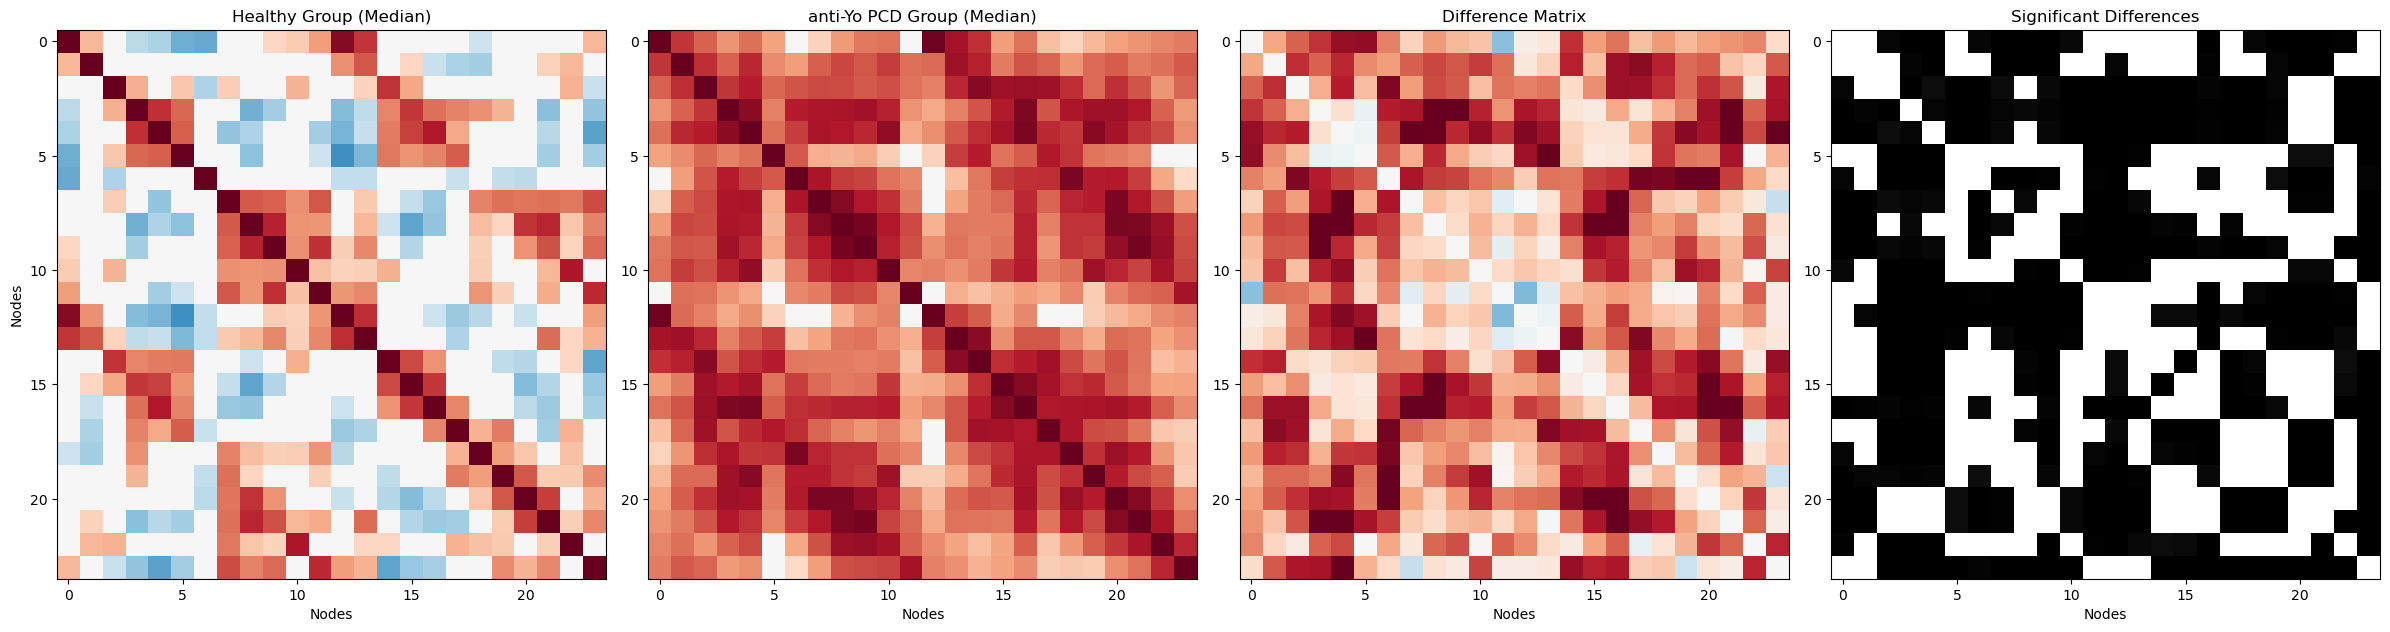

In [16]:
# Create combined adjacency matrix plot
plot_combined_adjacency_matrices(
    adj_matrix_group1, adj_matrix_group2, diff_matrix, sig_matrix,
    "../results/Combined_Adjacency_Matrices_with_Significance_12.png", 
    "Healthy Group (Median)", "anti-Yo PCD Group (Median)",
)

In [17]:
from graspologic.plot import heatmap

def plot_combined_adjacency_matrices(
    adj_group1, adj_group2, diff_matrix, sig_matrix, filename, groupname_1, groupname_2, labels
):
    """
    Plot adjacency matrices for two groups, their difference, and the significant clusters in a single layout using graspologic's heatmap.
    """
    fig, axes = plt.subplots(1, 4, figsize=(30, 10))
    font_scale = 1.5
    hier_label_fontsize = 20

    # Group 1
    heatmap(
        adj_group1,
        ax=axes[0],
        inner_hier_labels=labels,
        sort_nodes=True,
        cbar=False,
        title=groupname_1,
        font_scale=font_scale,
        hier_label_fontsize=hier_label_fontsize
    )
    axes[0].set_xlabel("Nodes")
    axes[0].set_ylabel("Nodes")

    # Group 2
    heatmap(
        adj_group2,
        ax=axes[1],
        inner_hier_labels=labels,
        sort_nodes=True,
        cbar=False,
        title=groupname_2,
        font_scale=font_scale,
        hier_label_fontsize=hier_label_fontsize
    )
    axes[1].set_xlabel("Nodes")

    # Difference Matrix
    heatmap(
        diff_matrix,
        ax=axes[2],
        inner_hier_labels=labels,
        sort_nodes=True,
        cbar=False,
        title="Difference Matrix",
        font_scale=font_scale,
        hier_label_fontsize=hier_label_fontsize
    )
    axes[2].set_xlabel("Nodes")

    # Significant Differences
    heatmap(
        sig_matrix,
        ax=axes[3],
        inner_hier_labels=labels,
        sort_nodes=True,
        cbar=False,
        title="Significant Differences",
        font_scale=font_scale,
        hier_label_fontsize=hier_label_fontsize
    )
    axes[3].set_xlabel("Nodes")

    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


/Users/tamara/anaconda3/envs/pcdanalysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


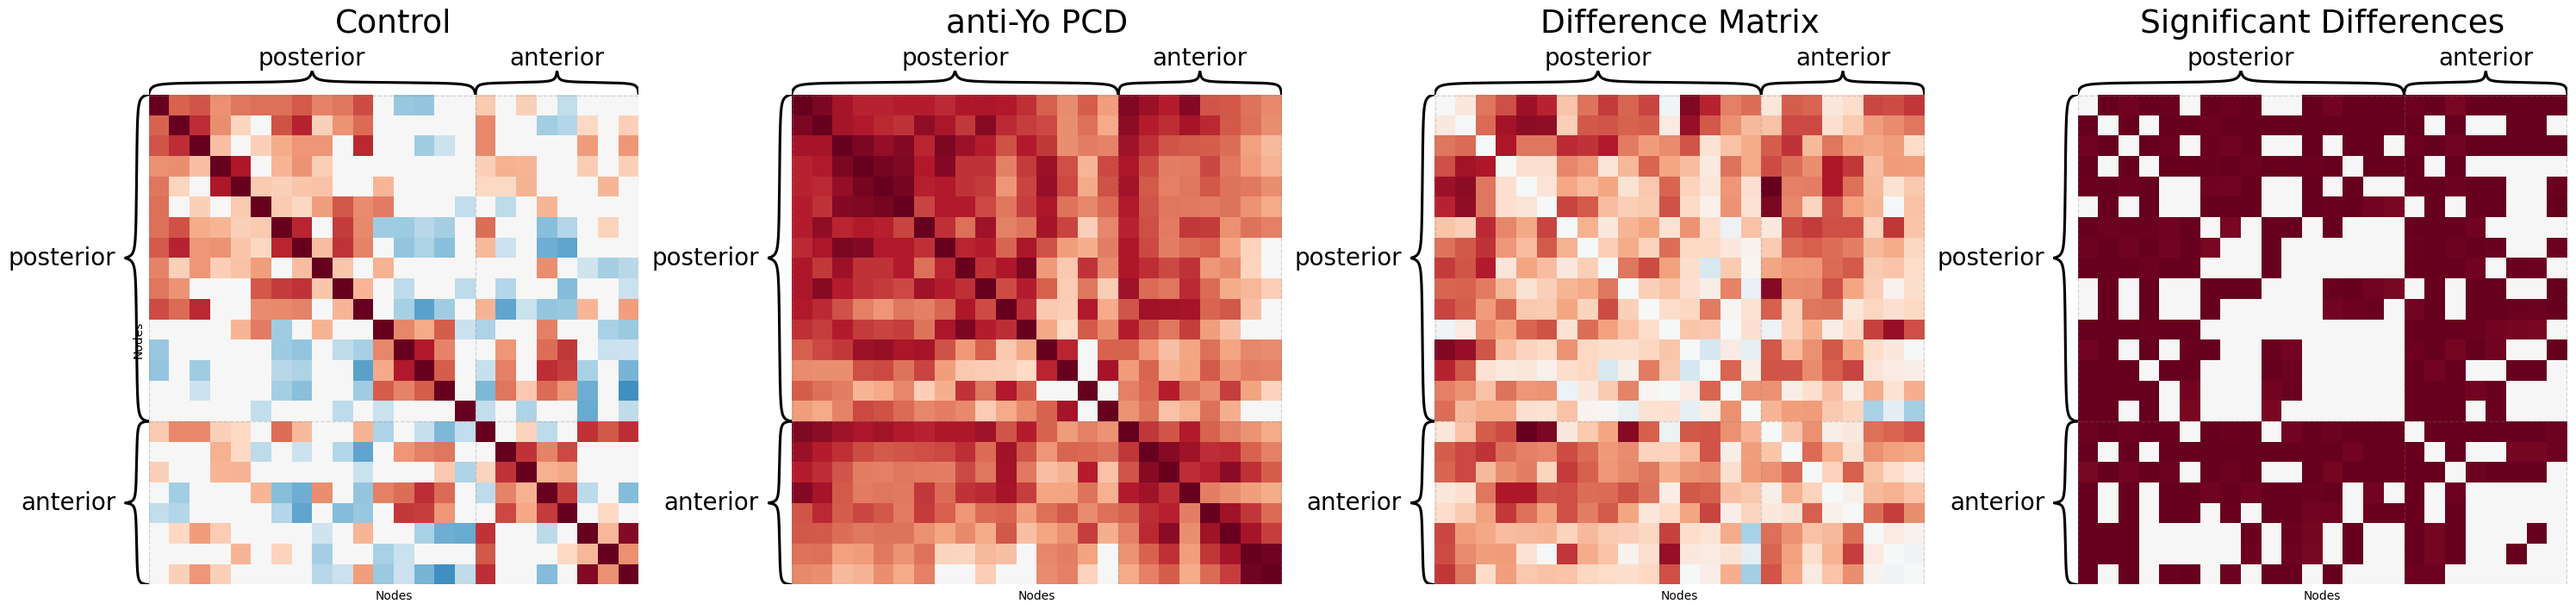

In [18]:
# Create combined adjacency matrix plot
plot_combined_adjacency_matrices(
    adj_matrix_group1, adj_matrix_group2, diff_matrix, sig_matrix,
    "../results/Combined_Adjacency_Matrices_with_Significance_12.svg", 
    "Control", "anti-Yo PCD",
    labels=labels
)

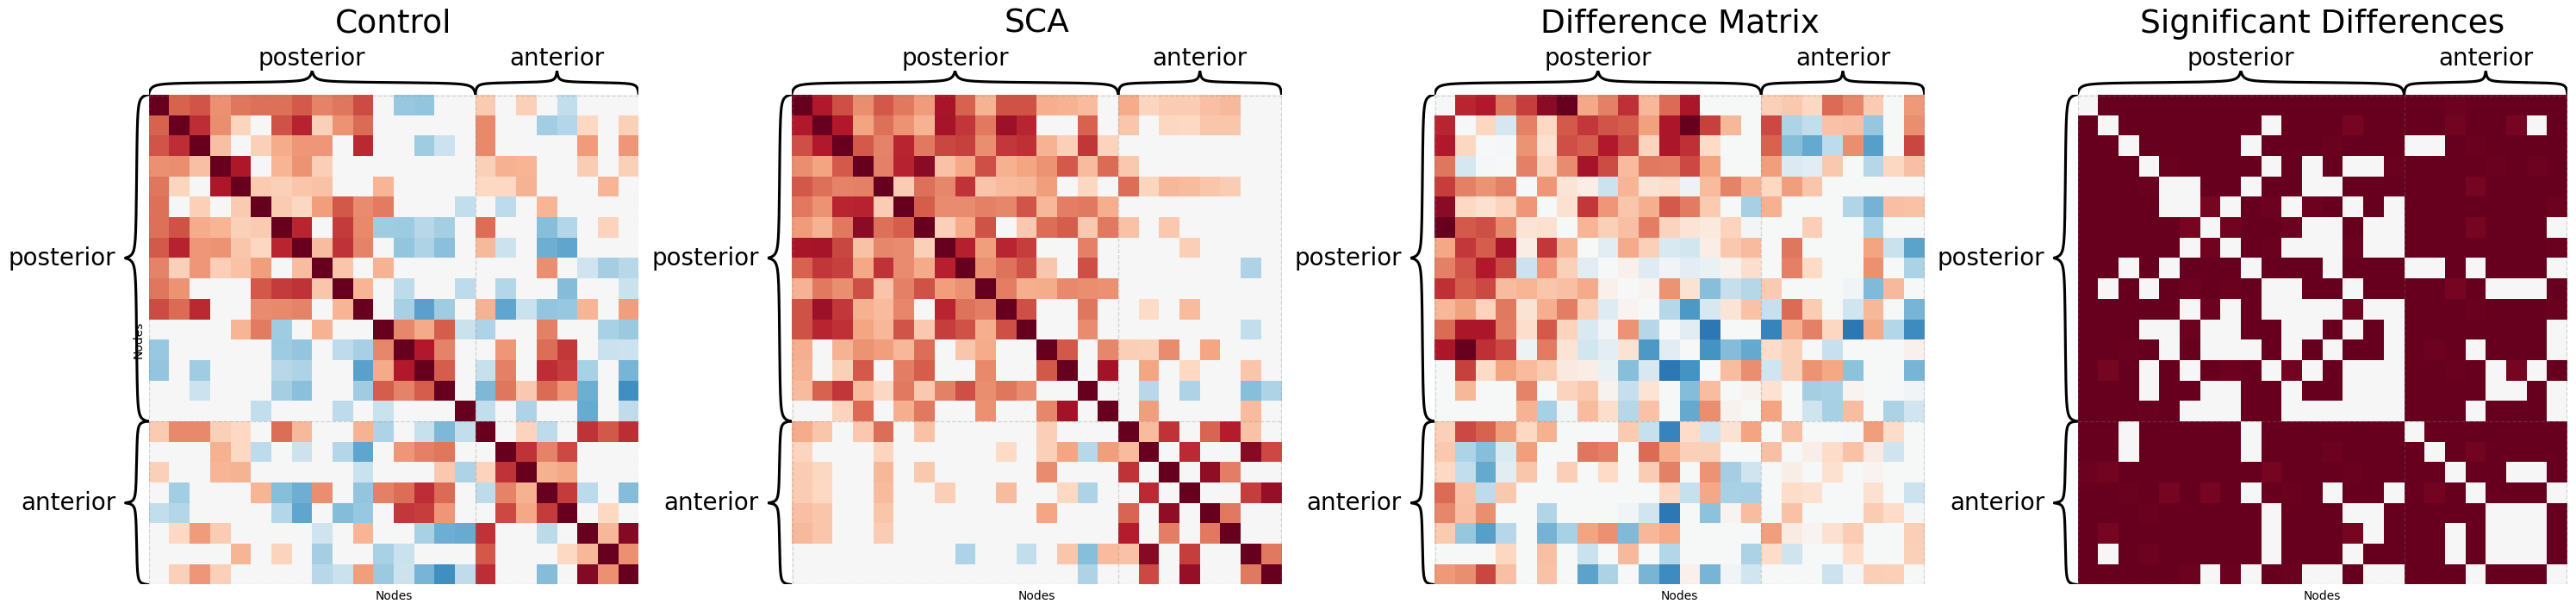

In [19]:
# Create combined adjacency matrix plot
plot_combined_adjacency_matrices(
    adj_matrix_group1, adj_matrix_group3, diff_matrix_13, sig_matrix_13,
    "../results/Combined_Adjacency_Matrices_with_Significance_13.svg", "Control", "SCA",
    labels
)

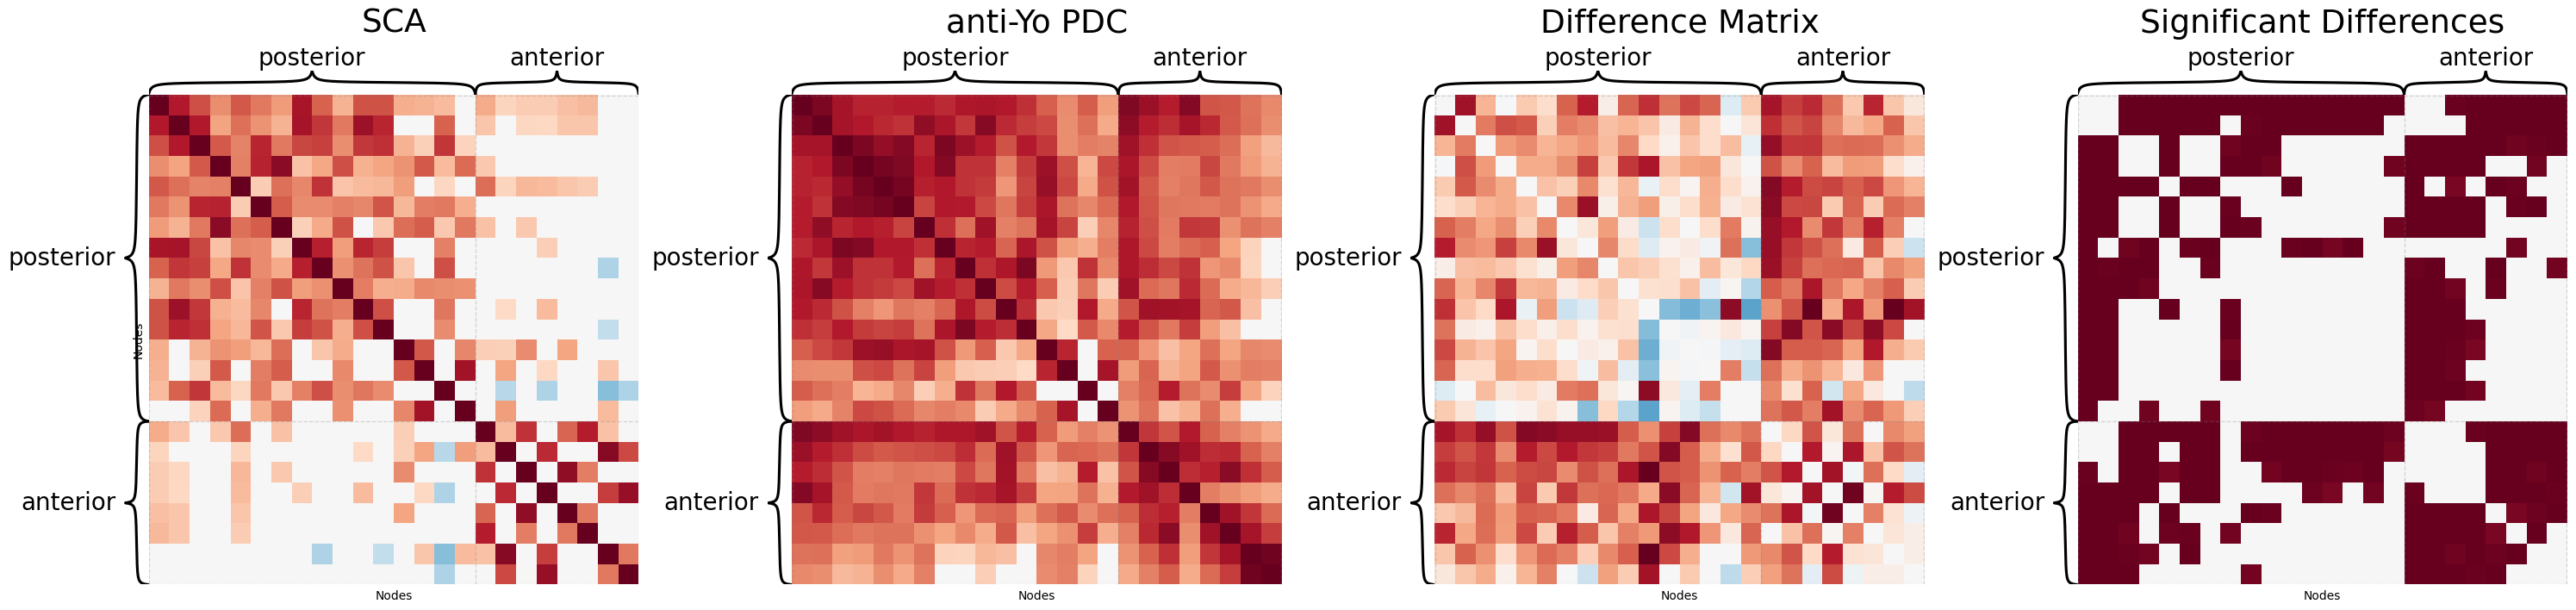

In [20]:
# Create combined adjacency matrix plot
plot_combined_adjacency_matrices(
    adj_matrix_group3, adj_matrix_group2, diff_matrix_23, sig_matrix_23, "../results/Combined_Adjacency_Matrices_with_Significance_23.svg",
    "SCA", "anti-Yo PDC",
    labels
)

### Network

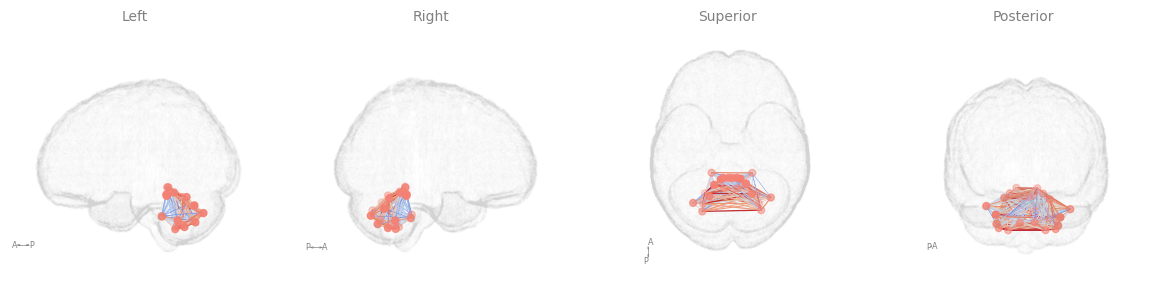

In [21]:
# Plot networks on the brain
#plot_network_on_brain(coords, adj_matrix_group1, "Healthy Group Network", "../results/Healthy_Network_Brain.png")
plot_network_on_brain(coords, adj_matrix_group2, "anti-Yo PCD Group Network", "../results/antiYoPCD_Network_Brain.svg")
#plot_network_on_brain(coords, diff_matrix, "Difference Network", "../results/Difference_Network_Brain.png")
#plot_network_on_brain(coords, sig_matrix, "Significant Differences Network", "../results/Significant_Differences_Network_Brain.png")

### Network analysis

In [22]:
import networkx as nx
import matplotlib.patches as mpatches

# Color mapping for labels
color_dict = {
    'posterior': '#aff8df',
    'anterior': '#ffcbc1'
}

# Define the mapping for node labels
lobule_mapping = {
    0: 'Lobule I-II',
    1: 'Lobule III',
    2: 'Lobule IV',
    3: 'Lobule V',
    4: 'Lobule VI',
    5: 'Lobule Crus I',
    6: 'Lobule Crus II',
    7: 'Lobule VIIB',
    8: 'Lobule VIIIA',
    9: 'Lobule VIIIB',
    10: 'Lobule IX',
    11: 'Lobule X',
    12: 'Lobule I-II (R)',
    13: 'Lobule III (R)',
    14: 'Lobule IV (R)',
    15: 'Lobule V (R)',
    16: 'Lobule VI (R)',
    17: 'Lobule Crus I (R)',
    18: 'Lobule Crus II (R)',
    19: 'Lobule VIIB (R)',
    20: 'Lobule VIIIA (R)',
    21: 'Lobule VIIIB (R)',
    22: 'Lobule IX (R)',
    23: 'Lobule X (R)'
}

collabels = 4*["anterior"]+8*['posterior']+4*["anterior"]+8*['posterior']

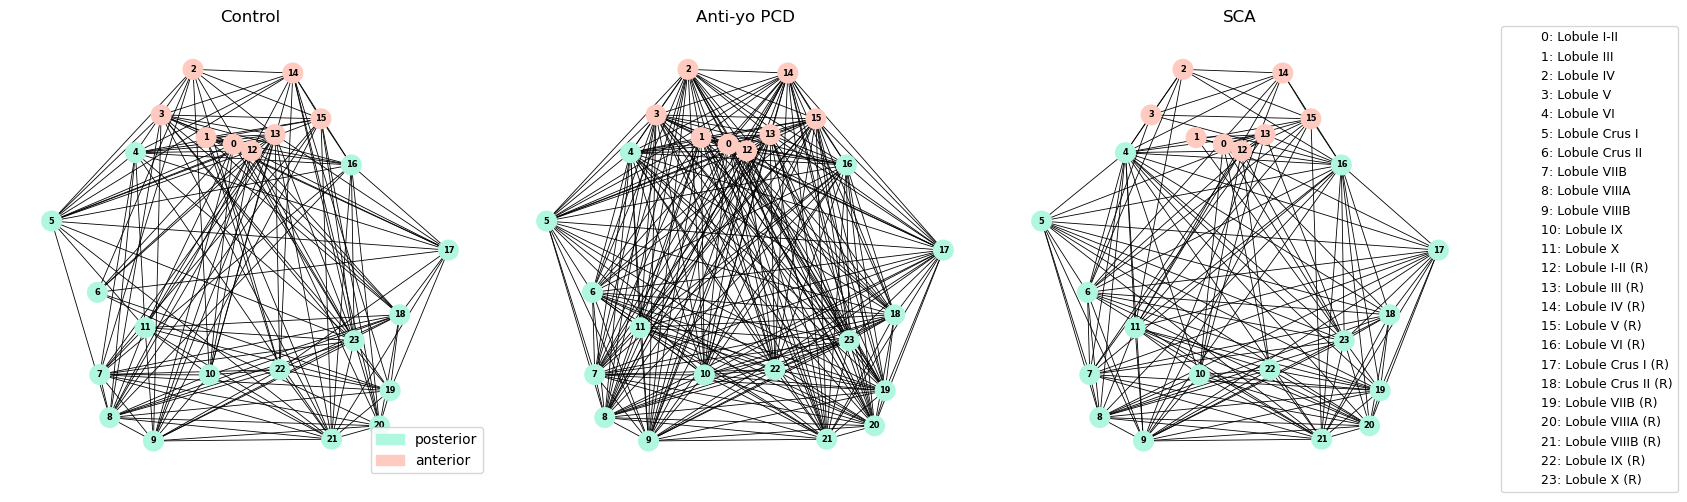

In [23]:
coords_2d = coords[:,[0,2]]

def create_graph(adj_matrix, lobule_mapping, collabels):
    A = adj_matrix.copy()
    np.fill_diagonal(A, 0)
    g = nx.from_numpy_array(A)
    for i in range(len(g.nodes)):
        g.nodes[i]['lobule'] = lobule_mapping[i]
        g.nodes[i]['lobulenr'] = list(lobule_mapping.keys())[i]
        g.nodes[i]['color'] = collabels[i]
    return g


# List of adjacency matrices
adj_matrices = [adj_matrix_group1, adj_matrix_group2, adj_matrix_group3]
titles = ["Control", "Anti-yo PCD", "SCA"]

# Create the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (adj_matrix, ax) in enumerate(zip(adj_matrices, axes)):
    g = create_graph(adj_matrix, lobule_mapping, collabels)
    
    # Get node colors directly from the graph
    node_colors = [color_dict[g.nodes[n]['color']] for n in g.nodes()]

    nx.draw_networkx(
        g,
        pos=coords_2d,
        labels=nx.get_node_attributes(g, 'lobulenr'),
        node_size=200,
        node_color=node_colors,
        with_labels=True,
        font_weight='bold',
        font_size=6,
        width=0.6,
        ax=ax
    )
    ax.set_title(titles[idx])
    ax.axis('off')

# Create the main legend for posterior and anterior
legend_tiles = [
    mpatches.Patch(color="#aff8df", label="posterior"),
    mpatches.Patch(color="#ffcbc1", label="anterior"),
]

# Add the main legend to the first subplot
axes[0].legend(handles=legend_tiles, loc="lower right")

# Create the lobule legend
lobule_legend_labels = [f"{key}: {value}" for key, value in lobule_mapping.items()]
lobule_legend_patches = [mpatches.Patch(color='white', label=label) for label in lobule_legend_labels]

# Add the lobule legend outside the plot
fig.legend(handles=lobule_legend_patches, loc="upper left", bbox_to_anchor=(1, 0.95), fontsize=9)

# Adjust layout to fit legends
plt.tight_layout()
plt.savefig('../results/network_graph.svg', bbox_inches='tight')
plt.show()

In [24]:
g1 = create_graph(adj_matrix_group1, lobule_mapping, collabels)
g2 = create_graph(adj_matrix_group2, lobule_mapping, collabels)
g3 = create_graph(adj_matrix_group3, lobule_mapping, collabels)

In [25]:
def calculate_graph_metrics(g):
    metrics = {}
    
    # Number of nodes and edges
    metrics['num_nodes'] = g.number_of_nodes()
    metrics['num_edges'] = g.number_of_edges()
    
    # Check if the graph is connected
    metrics['is_connected'] = nx.is_connected(g)
    metrics['num_components'] = nx.number_connected_components(g)
    
    # Global clustering coefficient
    metrics['global_clustering_coefficient'] = nx.average_clustering(g)
    
    # Global efficiency
    metrics['global_efficiency'] = nx.global_efficiency(g)
    
    # Small-worldness (if connected)
    if metrics['is_connected']:
        C = nx.average_clustering(g)
        L = nx.average_shortest_path_length(g)
        n = g.number_of_nodes()
        k = 2 * g.number_of_edges() / n
        C_rand = k / n
        L_rand = np.log(n) / np.log(k)
        metrics['small_worldness'] = (C / C_rand) / (L / L_rand)
    else:
        metrics['small_worldness'] = "Not applicable (disconnected graph)"
    
    # Node-level metrics
    metrics['node_strength'] = dict(g.degree(weight='weight'))
    metrics['betweenness_centrality'] = nx.betweenness_centrality(g)
    metrics['clustering_coefficient'] = nx.clustering(g)
    
    # Average shortest path length (for each component)
    component_path_lengths = []
    for component in nx.connected_components(g):
        subgraph = g.subgraph(component)
        if len(subgraph) > 1:
            component_path_lengths.append(nx.average_shortest_path_length(subgraph))
    metrics['avg_shortest_path_length'] = component_path_lengths
    
    # Participation coefficient (if the graph has communities)
    try:
        communities = list(nx.community.greedy_modularity_communities(g))
        metrics['participation_coefficient'] = nx.algorithms.participation_coefficient(g, communities)
    except:
        metrics['participation_coefficient'] = "Not calculated (requires community structure)"
    
    return metrics

# Example usage
# Assuming g is your NetworkX graph
# g = nx.Graph()  # Replace this with your actual graph

# Calculate metrics
metrics = calculate_graph_metrics(g)

# Print results
for metric, value in metrics.items():
    print(f"{metric}: {value}")


num_nodes: 24
num_edges: 151
is_connected: True
num_components: 1
global_clustering_coefficient: 0.731254100574921
global_efficiency: 0.7711352657004831
small_worldness: 1.192810507873778
node_strength: {0: 2.057219652528248, 1: 1.7524492117353474, 2: 3.248889273658946, 3: 2.6797690101989633, 4: 9.258212351979843, 5: 7.1937810349017175, 6: 8.880067495894846, 7: 6.855499285514164, 8: 6.917902289939051, 9: 7.397469237951466, 10: 5.136346207786048, 11: 5.562383426490355, 12: 4.042716711297587, 13: 3.5448880839866916, 14: 3.6546833475175875, 15: 4.7154710980746515, 16: 7.717017479133119, 17: 6.967054842689301, 18: 6.320243411220101, 19: 8.61591881889526, 20: 7.670096809197253, 21: 7.922775145095631, 22: 4.209916546815059, 23: 4.228917740219366}
betweenness_centrality: {0: 0.021657712072731837, 1: 0.0, 2: 0.001291001488629947, 3: 0.0, 4: 0.07450977875879061, 5: 0.004406002429717844, 6: 0.04846174905463442, 7: 0.00847449651797478, 8: 0.01191288948205944, 9: 0.026399226596855053, 10: 0.013655

In [26]:
# Calculate metrics
metrics1 = calculate_graph_metrics(g1)
metrics2 = calculate_graph_metrics(g2)
metrics3 = calculate_graph_metrics(g3)

In [27]:
def create_boxplot(data1, data2, data3, title, ax, name):
    df = pd.DataFrame({
        'Control': data1,
        'Anti-Yo PCD': data2,
        'SCA': data3
    })
    df_melted = df.melt(var_name='Group', value_name=name)
    
    custom_palette = {'Anti-Yo PCD': 'cornflowerblue', 'Control': 'turquoise', 'SCA': 'orange'}
    sns.boxplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
    
    _, p12 = stats.ttest_ind(data1, data2, equal_var=False)
    _, p13 = stats.ttest_ind(data1, data3, equal_var=False)
    _, p23 = stats.ttest_ind(data2, data3, equal_var=False)
    
    y_max = df_melted[name].max()
    add_significance_bar(0, 1, y_max*1.05, p12, ax)
    add_significance_bar(1, 2, y_max*1.15, p23, ax)
    add_significance_bar(0, 2, y_max*1.25, p13, ax)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_ylim(0, y_max*1.4)

def format_pvalue(p_value):
    if p_value < 0.001:
        return "p < 0.001"
    elif p_value < 0.01:
        return f"p = {p_value:.3f}"
    else:
        return f"p = {p_value:.2f}"

def add_significance_bar(start, end, height, p_value, ax):
    x1, x2 = start, end
    y, h = height, height * 0.05
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*.5, y+h, format_pvalue(p_value), ha='center', va='bottom', fontsize=10)

# Function to filter nodes based on color
def filter_nodes(g, metrics, color, metric):
    return [metrics[metric][n] for n in g.nodes() if g.nodes[n]['color'] == color]


/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_m

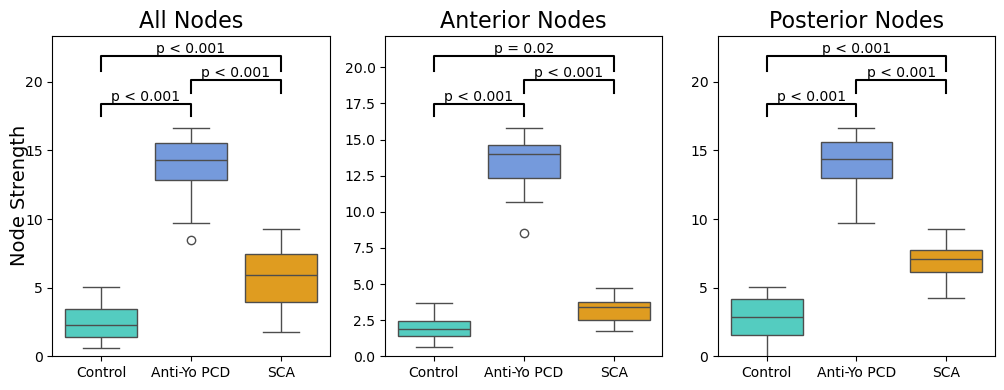

In [28]:
import seaborn as sns

metric_to_plot = 'node_strength'

# Create the main figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

# All nodes
create_boxplot(
    list(metrics1[metric_to_plot].values()),
    list(metrics2[metric_to_plot].values()),
    list(metrics3[metric_to_plot].values()),
    'All Nodes', ax1, 'Node Strength'
)

# Anterior nodes
create_boxplot(
    filter_nodes(g1, metrics1, 'anterior', metric_to_plot),
    filter_nodes(g2, metrics2, 'anterior', metric_to_plot),
    filter_nodes(g3, metrics3, 'anterior', metric_to_plot),
    'Anterior Nodes', ax2, 'Node Strength'
)

# Posterior nodes
create_boxplot(
    filter_nodes(g1, metrics1, 'posterior', metric_to_plot),
    filter_nodes(g2, metrics2, 'posterior', metric_to_plot),
    filter_nodes(g3, metrics3, 'posterior', metric_to_plot),
    'Posterior Nodes', ax3, 'Node Strength'
)

fig.text(0, 0.5, 'Node Strength', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.savefig('../results/node_strength.svg', bbox_inches='tight')
plt.show()


/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_m

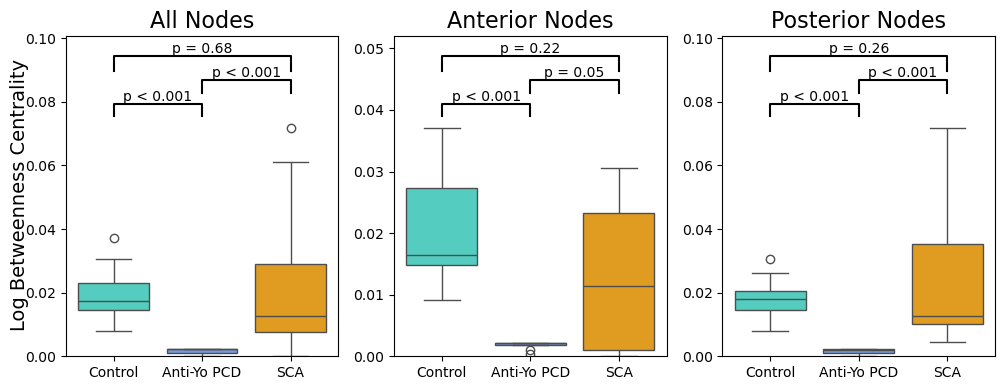

In [29]:
metric_to_plot = 'betweenness_centrality'

# Create the main figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# All nodes
create_boxplot(
    np.log1p(list(metrics1[metric_to_plot].values())),
    np.log1p(list(metrics2[metric_to_plot].values())),
    np.log1p(list(metrics3[metric_to_plot].values())),
    'All Nodes', ax1, 'Log Betweenness Centrality'
)

# Anterior nodes
create_boxplot(
    np.log1p(filter_nodes(g1, metrics1, 'anterior', metric_to_plot)),
    np.log1p(filter_nodes(g2, metrics2, 'anterior', metric_to_plot)),
    np.log1p(filter_nodes(g3, metrics3, 'anterior', metric_to_plot)),
    'Anterior Nodes', ax2, 'Log Betweenness Centrality'
)

# Posterior nodes
create_boxplot(
    np.log1p(filter_nodes(g1, metrics1, 'posterior', metric_to_plot)),
    np.log1p(filter_nodes(g2, metrics2, 'posterior', metric_to_plot)),
    np.log1p(filter_nodes(g3, metrics3, 'posterior', metric_to_plot)),
    'Posterior Nodes', ax3, 'Log Betweenness Centrality'
)

fig.text(0, 0.5, 'Log Betweenness Centrality', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.savefig('../results/betweenness_centrality.svg', bbox_inches='tight')
plt.show()


/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/1661152531.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=name, data=df_m

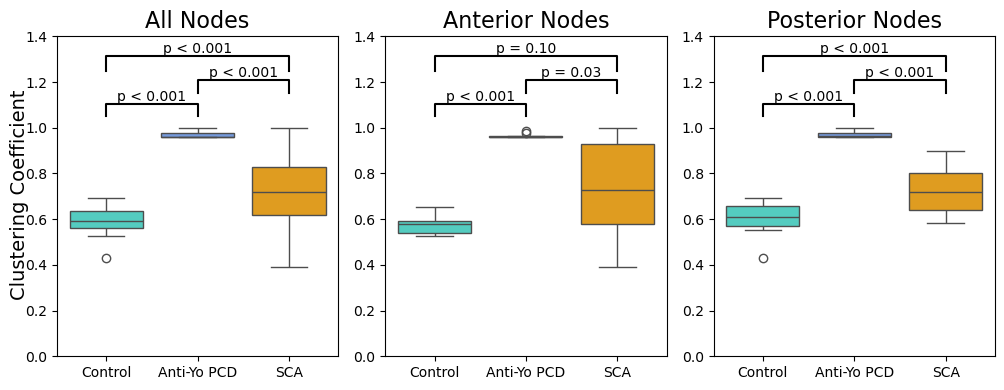

In [30]:
metric_to_plot = 'clustering_coefficient'

# Create the main figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

# All nodes
create_boxplot(
    list(metrics1[metric_to_plot].values()),
    list(metrics2[metric_to_plot].values()),
    list(metrics3[metric_to_plot].values()),
    'All Nodes', ax1, 'Clustering Coefficient'
)

# Anterior nodes
create_boxplot(
    filter_nodes(g1, metrics1, 'anterior', metric_to_plot),
    filter_nodes(g2, metrics2, 'anterior', metric_to_plot),
    filter_nodes(g3, metrics3, 'anterior', metric_to_plot),
    'Anterior Nodes', ax2, 'Clustering Coefficient'
)

# Posterior nodes
create_boxplot(
    filter_nodes(g1, metrics1, 'posterior', metric_to_plot),
    filter_nodes(g2, metrics2, 'posterior', metric_to_plot),
    filter_nodes(g3, metrics3, 'posterior', metric_to_plot),
    'Posterior Nodes', ax3, 'Clustering Coefficient'
)

fig.text(0, 0.5, 'Clustering Coefficient', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.savefig('../results/clustering_coefficient.svg', bbox_inches='tight')
plt.show()


/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/2031040182.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/2031040182.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
/var/folders/5v/phymts916gj_l1j7v8cs9s040000gn/T/ipykernel_40900/2031040182.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group', y=name, data=df_m

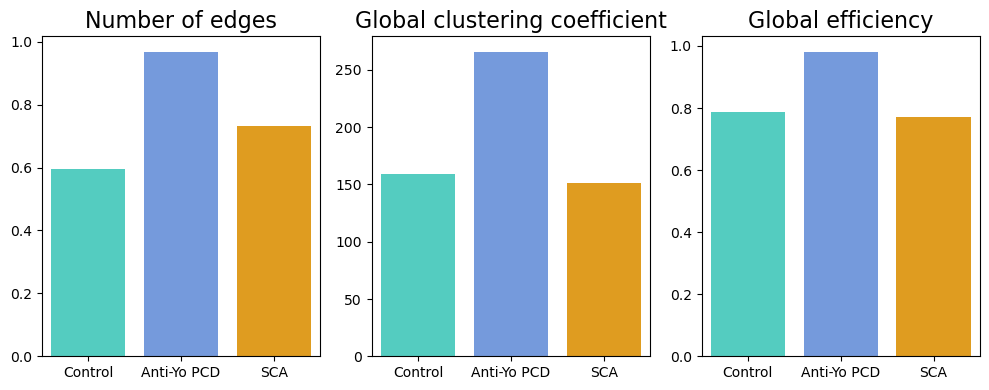

In [31]:
def create_barplot(data1, data2, data3, title, ax, name):
    df = pd.DataFrame({
        'Control': [data1],
        'Anti-Yo PCD': [data2],
        'SCA': [data3]
    })
    df_melted = df.melt(var_name='Group', value_name=name)
    
    custom_palette = {'Anti-Yo PCD': 'cornflowerblue', 'Control': 'turquoise', 'SCA': 'orange'}
    sns.barplot(x='Group', y=name, data=df_melted, palette=custom_palette, ax=ax)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(None)
    ax.set_ylabel(None)


# Create the main figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

metric_to_plot = 'num_edges'

create_barplot(
    metrics1[metric_to_plot],
    metrics2[metric_to_plot],
    metrics3[metric_to_plot],
    'Number of edges', ax1, 'Number of edges'
)

metric_to_plot = 'global_clustering_coefficient'



create_barplot(
    metrics1[metric_to_plot],
    metrics2[metric_to_plot],
    metrics3[metric_to_plot],
    'Global clustering coefficient', ax2, 'Global clustering coefficient'
)

metric_to_plot = 'global_efficiency'

create_barplot(
    metrics1[metric_to_plot],
    metrics2[metric_to_plot],
    metrics3[metric_to_plot],
    'Global efficiency', ax3, 'Global efficiency'
)

plt.tight_layout()
plt.savefig('../results/edges_clustering_coefficient_global_efficiency.svg', bbox_inches='tight')
plt.show()

### Other

In [32]:
def compute_network_metrics(g):
    node_count = len(g.nodes)
    edge_count = len(g.edges)
    avg_degree = sum(dict(g.degree()).values()) / node_count

    density = nx.density(g)

    clustering_coefficient = nx.average_clustering(g)

    if nx.is_connected(g):
        avg_path_length = nx.average_shortest_path_length(g)
    else:
        avg_path_length = float('inf')  # If the graph is not connected
    

    assortativity = nx.degree_assortativity_coefficient(g)

    if nx.is_connected(g):
        diameter = nx.diameter(g)
    else:
        diameter = float('inf')  # If the graph is not connected    
    
    avg_node_strength = sum(dict(g.degree(weight='weight')).values()) / node_count
    
    return {
        'Edge Count': edge_count,
        'Average Degree': avg_degree,
        'Density': density,
        'Clustering Coefficient': clustering_coefficient,
        'Average Path Length': avg_path_length,
        'Assortativity': assortativity,
        'Diameter': diameter,
        'Average Node Strength': avg_node_strength
    }

control_metrics = compute_network_metrics(g1)
anti_yo_pcd_metrics = compute_network_metrics(g2)
sca_metrics = compute_network_metrics(g3)


In [33]:
metrics_dict = {
    'Control': control_metrics,
    'Anti-yo PCD': anti_yo_pcd_metrics,
    'SCA': sca_metrics
}

df = pd.DataFrame.from_dict(metrics_dict, orient='index')

# Convert the DataFrame to LaTeX format
latex_output = df.to_latex(index=True, float_format="%.2f")

# Display or save the LaTeX output
print(latex_output)

# Optional: Save LaTeX to a file
with open("../results/network_results.tex", "w") as f:
    f.write(latex_output)

\begin{tabular}{lrrrrrrrr}
\toprule
 & Edge Count & Average Degree & Density & Clustering Coefficient & Average Path Length & Assortativity & Diameter & Average Node Strength \\
\midrule
Control & 159 & 13.25 & 0.58 & 0.60 & 1.42 & 0.03 & 2 & 2.41 \\
Anti-yo PCD & 266 & 22.17 & 0.96 & 0.97 & 1.04 & -0.12 & 2 & 13.73 \\
SCA & 151 & 12.58 & 0.55 & 0.73 & 1.47 & 0.05 & 3 & 5.69 \\
\bottomrule
\end{tabular}

